# Generic pipeline for segmentation tests

This notebook demonstrates how a pretrained model can be used to perform semantic segmentation on a set of images and compute some statistics on the identified objects. The model used below is the pretrained [`Mask2FormerForUniversalSegmentation`](https://huggingface.co/docs/transformers/en/model_doc/mask2former) model from Huggingface, which is an implementation of the [`Mask2Former`](https://arxiv.org/abs/2112.01527) model from FAIR.

In [49]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
import numpy as np

# --------------------------------------
from rich import print as pp

# --------------------------------------
import streetscapes as scs
from streetscapes import conf
from streetscapes.models import MaskFormerVistasPanoptic

In [50]:
data_dir = conf.DATA_DIR / "data"
parquet_dir =  data_dir / "parquet"
image_dir = data_dir / "images"

## Load a segmentation model

In this example, we instruct the model that all instances of `sky` and `water` should be treated as a single instance.

In [51]:
mfp = MaskFormerVistasPanoptic(labels_to_fuse={"sky", "water"})

Select a few images at random.

<span style="color:red;">Note</span>: please make sure that you download some images first (cf. `download_city_images.ipynb`).

In [52]:
images = list(np.random.choice(list(image_dir.glob("*.jpeg")), 2, replace=False))
[image.name for image in images]

['137690604953809.jpeg', '1405394833216306.jpeg']

Choose one of those as a test image.

In [53]:
test_image = images[0].name

## Segment the images

In [54]:
segmentations = mfp.segment(images)

Streetscapes | 2025-02-20@11:55:32 | Segmenting images...


100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


Show the segmentation result for our test image.

In [55]:
segmentations[test_image]['segmentation']

tensor([[10, 10, 10,  ..., 18, 18, 18],
        [10, 10, 10,  ..., 18, 18, 18],
        [10, 10, 10,  ..., 18, 18, 18],
        ...,
        [19, 19, 19,  ..., 19, 19, 19],
        [19, 19, 19,  ..., 19, 19, 19],
        [19, 19, 19,  ..., 19, 19, 19]], dtype=torch.int32)

## Compute the statistics

The result is a dictionary of statistics for each segment of each category type.

In [56]:
stats = mfp.compute_statistics(images, segmentations)

Streetscapes | 2025-02-20@11:55:36 | Computing statistics...


100%|██████████| 2/2 [00:13<00:00,  6.50s/it]


Show a subset of the statistics

In [57]:
pp(stats[test_image]['building'])

[
    {
        'colour': {
            'median': [0.5450980392156862, 0.5176470588235295, 0.4666666666666667],
            'mode': [1.0, 0.5490196078431373, 0.4666666666666667],
            'mean': [0.5189899915330515, 0.5018750548728397, 0.47099781212338343],
            'sd': [0.2621367136545519, 0.24728393070184979, 0.22709046772492258]
        },
        'hue': {
            'median': 0.1388888888888889,
            'mode': 0.16666666666666666,
            'mean': 0.2759296169754872,
            'sd': 0.2505971459873175
        },
        'saturation': {
            'median': 0.15151515151515144,
            'mode': 0.0,
            'mean': 0.1807785685896862,
            'sd': 0.1265575765729685
        },
        'value': {
            'median': 0.5764705882352941,
            'mode': 1.0,
            'mean': 0.5427735879851879,
            'sd': 0.2544597888776419
        },
        'area': 0.4648475646972656
    }
]

### Visualise the the segmentation results

Select a few categories that we might be interested in.

In [58]:
categories = {"sky", "building", "road", "vegetation", "water", "sidewalk", "person", "car", "bicyclist"}

Display the segmentation results.

Streetscapes | 2025-02-20@11:55:49 | Segmenting images...


100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


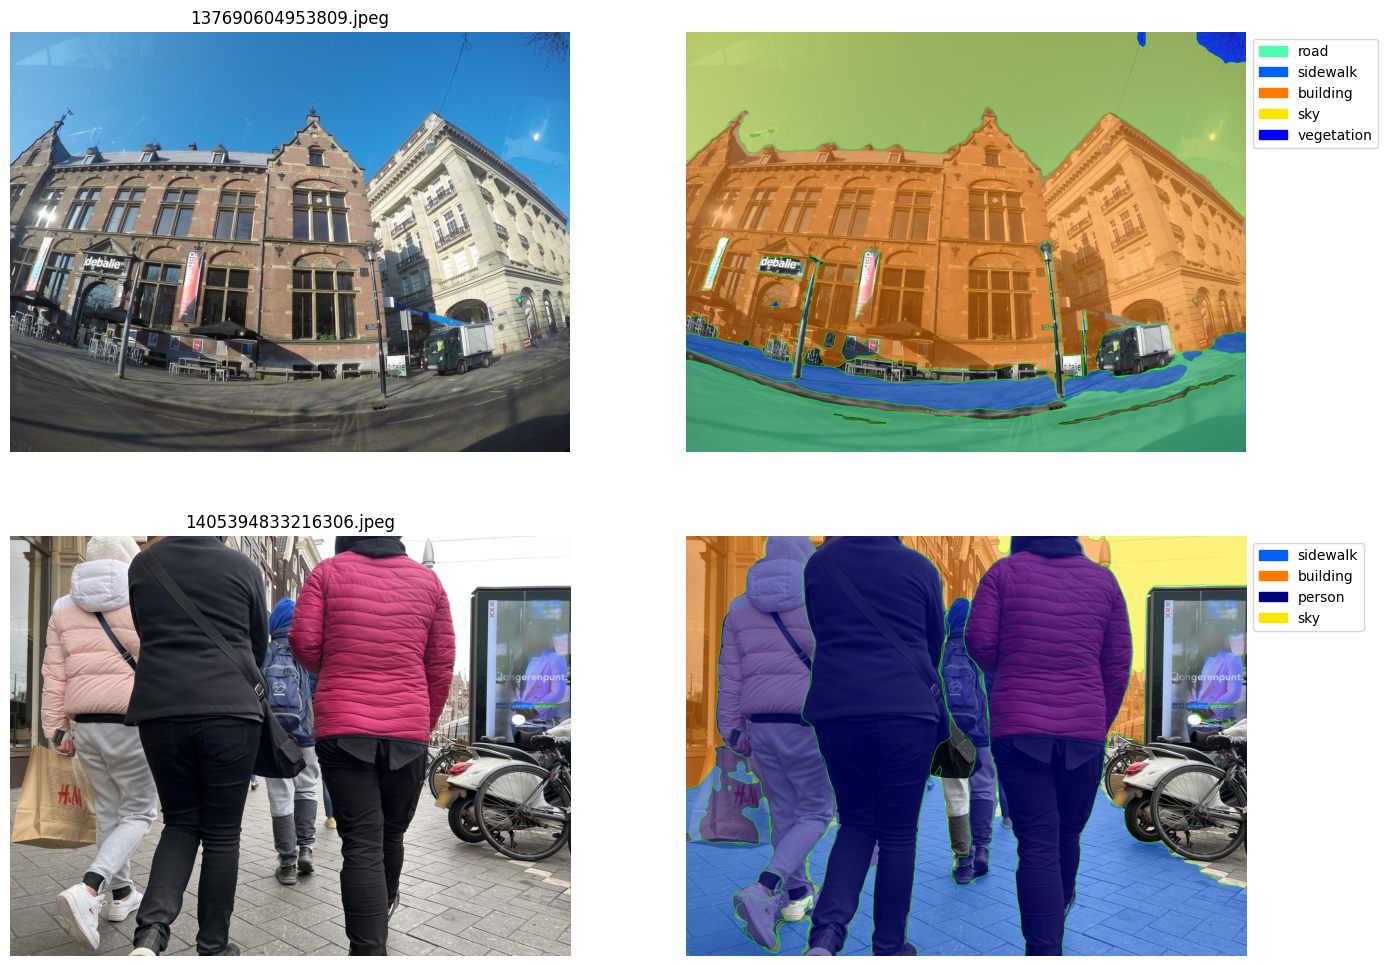

In [59]:
fig, ax, image_stats = mfp.visualise_segmentation(images, categories, stats=stats)

Show a subset of the statistics for one of the categories that we are interested in.

In [60]:
pp(image_stats[test_image]['building'])

[
    {
        'colour': {
            'median': [0.5450980392156862, 0.5176470588235295, 0.4666666666666667],
            'mode': [1.0, 0.5490196078431373, 0.4666666666666667],
            'mean': [0.5189899915330515, 0.5018750548728397, 0.47099781212338343],
            'sd': [0.2621367136545519, 0.24728393070184979, 0.22709046772492258]
        },
        'hue': {
            'median': 0.1388888888888889,
            'mode': 0.16666666666666666,
            'mean': 0.2759296169754872,
            'sd': 0.2505971459873175
        },
        'saturation': {
            'median': 0.15151515151515144,
            'mode': 0.0,
            'mean': 0.1807785685896862,
            'sd': 0.1265575765729685
        },
        'value': {
            'median': 0.5764705882352941,
            'mode': 1.0,
            'mean': 0.5427735879851879,
            'sd': 0.2544597888776419
        },
        'area': 0.4648475646972656
    }
]

## Process images from a subset

The segmentation model also provides a convenience method to process all the images in a subset of the `streetscapes` dataset.

Load a subset file.

In [61]:
amsterdam_side = parquet_dir / "amsterdam_side.parquet"

Select a file to save the statistics to.

In [62]:
out_file_path = amsterdam_side.with_name(f"{amsterdam_side.stem}-stats.parquet")

Process all images in the dataset and save the statistics to a Parquet file in one go.

In [63]:
(ds_images, ds_segmented, ds_stats) = mfp.segment_from_dataset(amsterdam_side, sample=5, out_file_path=out_file_path)

Streetscapes | 2025-02-20@11:55:55 | Segmenting images...


100%|██████████| 5/5 [00:09<00:00,  1.89s/it]

Streetscapes | 2025-02-20@11:56:04 | Computing statistics...



100%|██████████| 5/5 [00:40<00:00,  8.16s/it]


The statistics can be loaded back into a dictionary format.

In [64]:
loaded_stats = mfp.load_stats(out_file_path)

Pick an image file and check that the computed statistics and the loaded statistics are identical

In [65]:
test_image = list(ds_images.keys())[0]

A sample item from the computed statistics

In [66]:
pp(ds_stats[test_image]['building'])

[
    {
        'colour': {
            'median': [0.21176470588235294, 0.21176470588235294, 0.20784313725490197],
            'mode': [0.3254901960784314, 0.3411764705882353, 0.34901960784313724],
            'mean': [0.21974507144542482, 0.22475790219967756, 0.22313544213525494],
            'sd': [0.13864893302012635, 0.1411937001555946, 0.14504083974392187]
        },
        'hue': {
            'median': 0.4166666666666667,
            'mode': 0.5714285714285715,
            'mean': 0.3680969691350548,
            'sd': 0.23990460302281344
        },
        'saturation': {
            'median': 0.11538461538461552,
            'mode': 0.0,
            'mean': 0.16999298401770976,
            'sd': 0.1652469110932919
        },
        'value': {
            'median': 0.22745098039215686,
            'mode': 0.3529411764705882,
            'mean': 0.23681457801243316,
            'sd': 0.14411896767896573
        },
        'area': 0.1481297810872396
    }
]

The same item from the loaded statistics

In [67]:
pp(loaded_stats[test_image]["building"])

[
    {
        'colour': {
            'median': [0.21176470588235294, 0.21176470588235294, 0.20784313725490197],
            'mode': [0.3254901960784314, 0.3411764705882353, 0.34901960784313724],
            'mean': [0.21974507144542482, 0.22475790219967756, 0.22313544213525494],
            'sd': [0.13864893302012635, 0.1411937001555946, 0.14504083974392187]
        },
        'hue': {
            'median': 0.4166666666666667,
            'mode': 0.5714285714285715,
            'mean': 0.3680969691350548,
            'sd': 0.23990460302281344
        },
        'saturation': {
            'median': 0.11538461538461552,
            'mode': 0.0,
            'mean': 0.16999298401770976,
            'sd': 0.1652469110932919
        },
        'value': {
            'median': 0.22745098039215686,
            'mode': 0.3529411764705882,
            'mean': 0.23681457801243316,
            'sd': 0.14411896767896573
        },
        'area': 0.1481297810872396
    }
]